# Модель кредитного скоринга для банка

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Описание датасета**  

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from scipy.stats import shapiro, probplot

import warnings
warnings.simplefilter('ignore')
%matplotlib inline

### Функции и скрипты

In [2]:
# Фиксим шрифты
def fix_font():
    plt.rc('font', size=14)         # размер шрифта по умолчанию
    plt.rc('axes', titlesize=13)    # размер шрифта оси
    plt.rc('axes', labelsize=13)    # размер шрифта для меток x и y
    plt.rc('xtick', labelsize=11)   # размер шрифта по оси х
    plt.rc('ytick', labelsize=11)   # размер шрифта по оси y
    plt.rc('legend', fontsize=10)   # размер шрифта legend
    plt.rc('figure', titlesize=16)  # размер шрифта figure title

    
# Функция группировки признаков по типам
def features_group(df):
    TARGET_NAME = 'Credit Default'
    try: BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
    except: BASE_FEATURE_NAMES = df.columns.tolist()
    CAT_FEATURE_NAMES = df[BASE_FEATURE_NAMES].select_dtypes(include='object').columns.tolist()
    NUM_FEATURE_NAMES = df[BASE_FEATURE_NAMES].columns.drop(CAT_FEATURE_NAMES).tolist()
    return TARGET_NAME, BASE_FEATURE_NAMES, NUM_FEATURE_NAMES, CAT_FEATURE_NAMES


# Функция приведения типов
def astype_col(df, colgroup, coltype):
    for colname in colgroup:
        df[colname] = df[colname].astype(coltype)
    return df


# Функция перевода категориальных признаков в dummies
def dummies_col(df, colgroup):
    for colname in colgroup:
        df = pd.concat([df, pd.get_dummies(df[colname], prefix=colname)], axis=1)
    return df


# Функция удаления набора признаков оставшихся в старом формате
def drop_columns(df):
    df = df.drop('Home Ownership', axis=1)
    df = df.drop('Years in current job', axis=1)
    df = df.drop('Purpose', axis=1)
    df = df.drop('Term', axis=1)    
    return df


# Функция нормализации данных
def normalization_df(df, colgroup):
    scaler = StandardScaler()
    df_norm = df.copy()
    df_norm[colgroup] = scaler.fit_transform(df_norm[colgroup])
    df = df_norm.copy()
    return df

    
# Функция отчета по классификации
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('\nTRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('\nTEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('\nCONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

    
# Функция оценки предсказания
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

    
# Функция балансировки
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    return df.sample(frac=1) 


# Функции обработки выбросов
def preprocess_outlier(df, col, threshold):
    df.loc[df[col] > threshold, col] = np.nan
    return df

def fix_outlier(df):
    df = preprocess_outlier(df, 'Annual Income', threshold=8000000)
    df = preprocess_outlier(df, 'Tax Liens', threshold=7)
    df = preprocess_outlier(df, 'Number of Open Accounts', threshold=40)
    df = preprocess_outlier(df, 'Years of Credit History', threshold=50)
    df = preprocess_outlier(df, 'Maximum Open Credit', threshold=50000000)
    df = preprocess_outlier(df, 'Number of Credit Problems', threshold=5)
    df = preprocess_outlier(df, 'Months since last delinquent', threshold=48)
    df = preprocess_outlier(df, 'Bankruptcies', threshold=1)
    df = preprocess_outlier(df, 'Current Loan Amount', threshold= 40000000)
    df = preprocess_outlier(df, 'Current Credit Balance', threshold=400000)
    df = preprocess_outlier(df, 'Monthly Debt', threshold=80000)
    df = preprocess_outlier(df, 'Credit Score', threshold=1000)
    return df


# Функции обработки пропусков
def outliers(df):
    # Корректировка значений
    df.loc[df['Years in current job'] == '10+ years', 'Years in current job'] = '10 years'
    df.loc[df['Years in current job'] == '< 1 year', 'Years in current job'] = '1 year'
    
    # Обработка пропусков
    df.loc[df['Annual Income'].isnull(), 'Annual Income'] = df['Annual Income'].mean()
    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = '10 years'
    df.loc[df['Tax Liens'].isnull(), 'Tax Liens'] = df['Tax Liens'].mean()
    df.loc[df['Number of Open Accounts'].isnull(), 'Number of Open Accounts'] = df['Number of Open Accounts'].mean()
    df.loc[df['Years of Credit History'].isnull(), 'Years of Credit History'] = df['Years of Credit History'].mean()
    df.loc[df['Maximum Open Credit'].isnull(), 'Maximum Open Credit'] = df['Maximum Open Credit'].median()
    df.loc[df['Number of Credit Problems'].isnull(), 'Number of Credit Problems'] = df['Number of Credit Problems'].mean()
    df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
    df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0.0
    df.loc[df['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df['Current Loan Amount'].mean()
    df.loc[df['Current Credit Balance'].isnull(), 'Current Credit Balance'] = df['Current Credit Balance'].mean()
    df.loc[df['Monthly Debt'].isnull(), 'Monthly Debt'] = df['Monthly Debt'].mean()
    df.loc[df['Credit Score'].isnull(), 'Credit Score'] = df['Credit Score'].mean()
    return df


# Функция обработки пропусков при помощи модели RandomForestRegressor
# def preprocess_outliers(data, target_col):
#     data = data.copy()
    
#     features = data.columns
    
#     data = data[features]
    
#     train = data[~data[target_col].isna()]
#     predict_data = data[data[target_col].isna()]

#     X = train.drop(columns=target_col)
#     y = train[target_col]
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                         test_size=0.2,
#                                                         shuffle=True,
#                                                         random_state=32)
    
#     model = RandomForestRegressor(n_estimators=100,
#                                   max_depth=10,
#                                   random_state=42,
#                                   verbose=1)
#     model.fit(X_train, y_train)
    
#     pred_train = model.predict(X_train)
#     pred_test = model.predict(X_test)
    
#     print(f"r2 на train: {r2_score(y_train, pred_train)}")
#     print(f"r2 на test: {r2_score(y_test, pred_test)}")

#     pred = model.predict(predict_data.drop(columns=target_col))

#     data.loc[data[target_col].isna(), target_col] = list(pred)
#     return model, data


# Функция определения важности признаков
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

## Базовая модель (baseline)

### Загрузка и обзор данных

In [3]:
DATASET_PATH = 'train.csv'
df = pd.read_csv(DATASET_PATH)

In [4]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Информация о трейне + кол-во пропусков**

In [5]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

**Количественные признаки**

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


**Категориальные признаки**

In [7]:
for colname in df.select_dtypes(include='object').columns:
    print(str(colname) + '\n\n' + str(df[colname].value_counts()) + '\n\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation

### Предобработка данных

**Обработка пропусков**

In [8]:
# Корректировка значений
df.loc[df['Years in current job'] == '10+ years', 'Years in current job'] = '10 years'
df.loc[df['Years in current job'] == '< 1 year', 'Years in current job'] = '1 year'

In [9]:
# Обработка пропусков
df.loc[df['Annual Income'].isnull(), 'Annual Income'] = df['Annual Income'].median()
df.loc[df['Years in current job'].isnull(), 'Years in current job'] = '10 years'
df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0.0
df.loc[df['Credit Score'].isnull(), 'Credit Score'] = df['Credit Score'].median()

In [10]:
df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### Обучение базовой модели

**Выделение целевой переменной и групп признаков**

In [11]:
# Группировка признаков по типам
TARGET_NAME, BASE_FEATURE_NAMES, NUM_FEATURE_NAMES, CAT_FEATURE_NAMES = features_group(df)

**Нормализация данных**

In [12]:
# Нормализация данных
df = normalization_df(df, NUM_FEATURE_NAMES)

**Переводим признаки в dummies**

In [13]:
# Переводим все категориальные признаки в dummies
df = dummies_col(df, CAT_FEATURE_NAMES)

In [14]:
# Удаляем набор признаков оставшихся в старом формате
df = drop_columns(df)

In [15]:
# Перегруппировка признаков по типам
TARGET_NAME, BASE_FEATURE_NAMES, NUM_FEATURE_NAMES, CAT_FEATURE_NAMES = features_group(df)

**Разбиваем выборку на трейн и на тест**

In [16]:
# Разделяем набор признаков
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]

# Разбиваем выборку на трейн и на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

# Выводим результат разбиения
X_train.shape, X_test.shape

((5250, 43), (2250, 43))

### Расчет метрики и сохранение модели

**Обучение базовой модели**

In [17]:
# Можно посмотреть параметры любой модели или функции через Shift + Tab
# Методы балансировки (class_weights):
# None — Все веса классов устанавливаются равными 1
# Balanced — Вес класса на основе общего веса
# SqrtBalanced — Вес класса на основе общего количества объектов в каждом классе

In [18]:
# Рассчитаем соотношение дисбаланса
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance = round(disbalance, 2)
disbalance

2.55

In [19]:
# CatBoost
# %%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, class_weights=[1, disbalance])
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)


TRAIN

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      3771
           1       0.76      0.90      0.82      1479

    accuracy                           0.89      5250
   macro avg       0.86      0.89      0.87      5250
weighted avg       0.90      0.89      0.89      5250


TEST

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1616
           1       0.49      0.55      0.52       634

    accuracy                           0.71      2250
   macro avg       0.65      0.66      0.65      2250
weighted avg       0.72      0.71      0.71      2250


CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1247  369
1                285  349


**Сохраняем модель**

In [20]:
# with open('model_catb.pkl', 'wb') as file:
#     pickle.dump(model_catb, file)

## EDA. Анализ данных

### Загрузка данных

In [21]:
TRAIN_DATASET_PATH = 'train.csv'
df = pd.read_csv(TRAIN_DATASET_PATH)

In [22]:
# Фиксим шрифты
fix_font()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Целевая переменная

In [24]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Выделение целевой переменной и групп признаков**

In [25]:
# Группировка признаков по типам
TARGET_NAME, BASE_FEATURE_NAMES, NUM_FEATURE_NAMES, CAT_FEATURE_NAMES = features_group(df)

In [26]:
# Приведение типов
df = astype_col(df, CAT_FEATURE_NAMES, coltype='str')

In [27]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

**Корреляция целевой переменной с базовыми признаками**

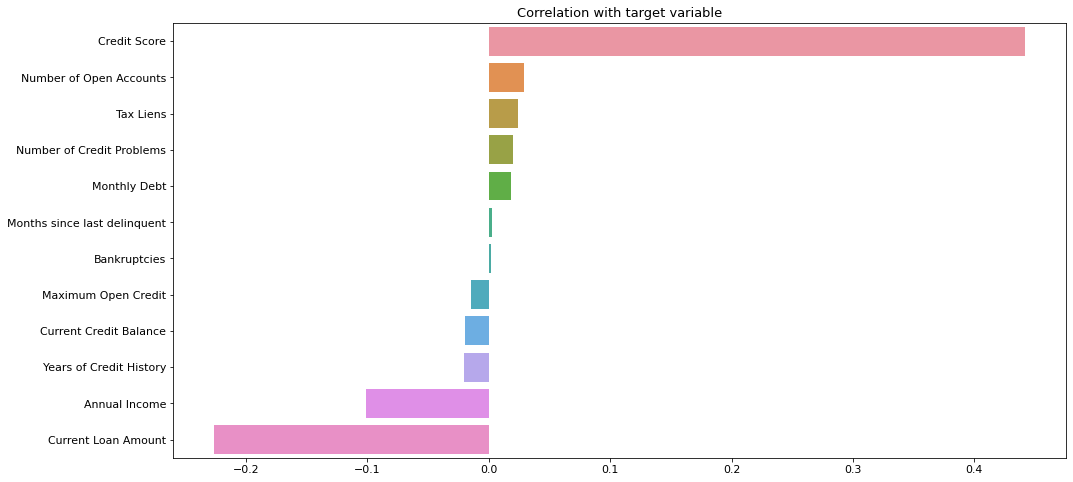

In [28]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(16, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Оценка признака "Credit Score" в разрезе целевой переменной**

Как видим **Credit Score** имеет выбросы, возьмем для анализа Credit Score в пределах 1000.

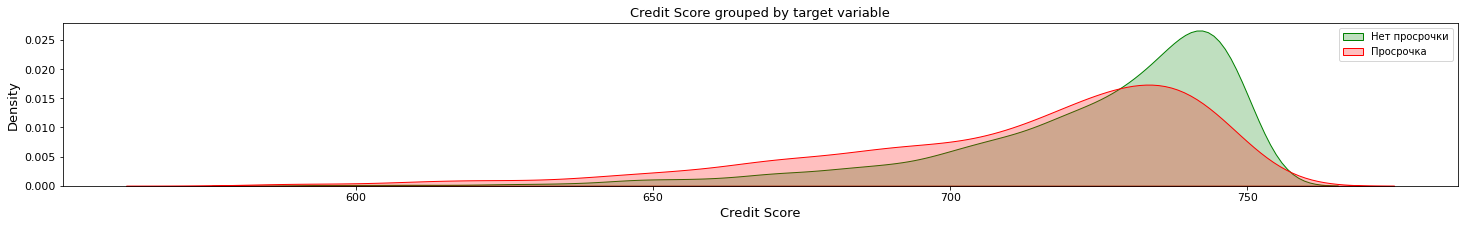

In [29]:
credit_score_with_target = df[df['Credit Score'] < 1000][['Credit Score', TARGET_NAME]]
credit_score = credit_score_with_target['Credit Score']
credit_score_target_0 = credit_score[credit_score_with_target[TARGET_NAME] == 0]
credit_score_target_1 = credit_score[credit_score_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(25, 3))

sns.kdeplot(credit_score_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Просрочка', color='r')
plt.legend(loc='upper right')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

**Распределение Credit Score**

In [30]:
# Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка
shapiro(credit_score)

ShapiroResult(statistic=0.8480203151702881, pvalue=0.0)

Значение p-value меньше 0.05, следовательно распределение отлично от "нормального".

((array([-3.66217536, -3.42845283, -3.29971701, ...,  3.29971701,
          3.42845283,  3.66217536]),
  array([585., 586., 588., ..., 751., 751., 751.])),
 (25.477712801146733, 720.7059354140357, 0.9209213578101848))

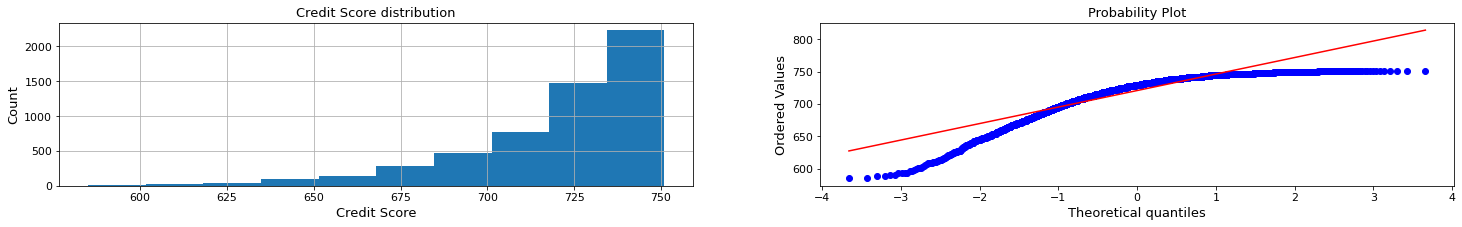

In [31]:
plt.figure(figsize=(25, 3))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score.hist()

plt.subplot(122)
probplot(credit_score, dist='norm', plot=plt)

Графическое представление подтверждает, что распределение отлично от "нормального".

### Анализ признаков

#### Матрица корреляций

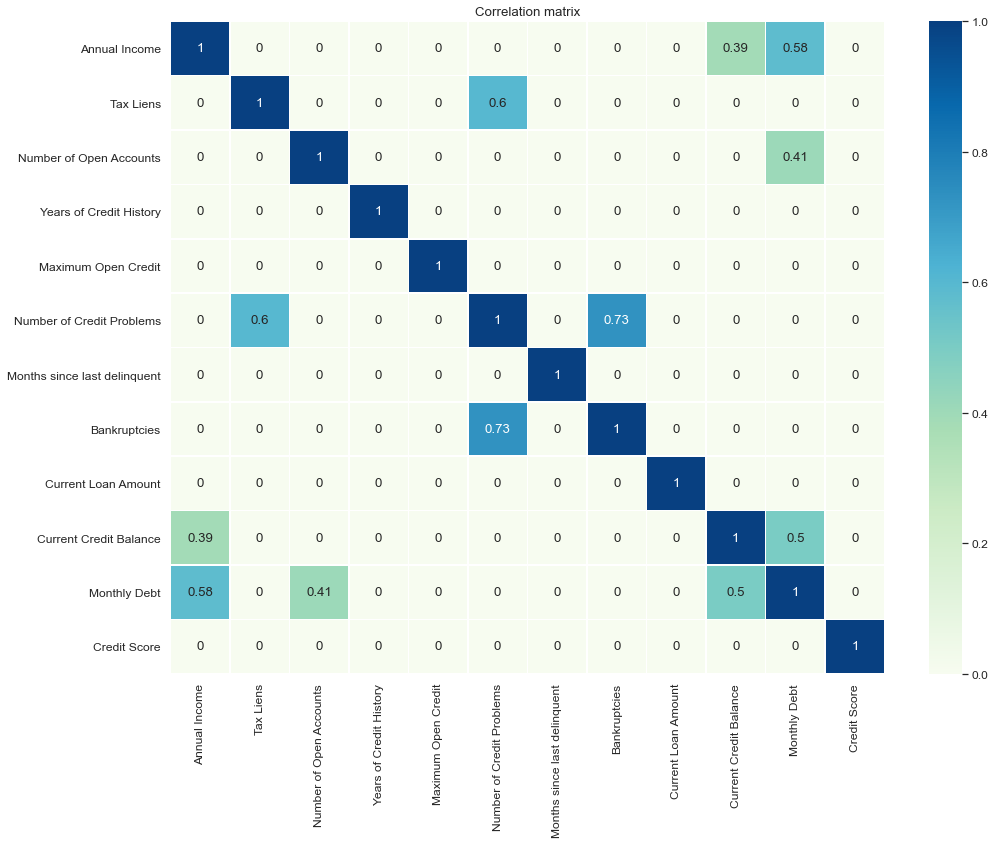

In [32]:
plt.figure(figsize = (16,12))

sns.set(font_scale=1.1)

corr_matrix = df[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [33]:
# Фиксим шрифты
fix_font()

#### Количественные признаки

In [34]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


#### Категориальные признаки

In [35]:
for colname in df.select_dtypes(include='object').columns:
    print(str(colname) + '\n\n' + str(df[colname].value_counts()) + '\n\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64

****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expense

## Предобработка данных

### Обработка выбросов

Выведем числовые признаки для проверки на выбросы.

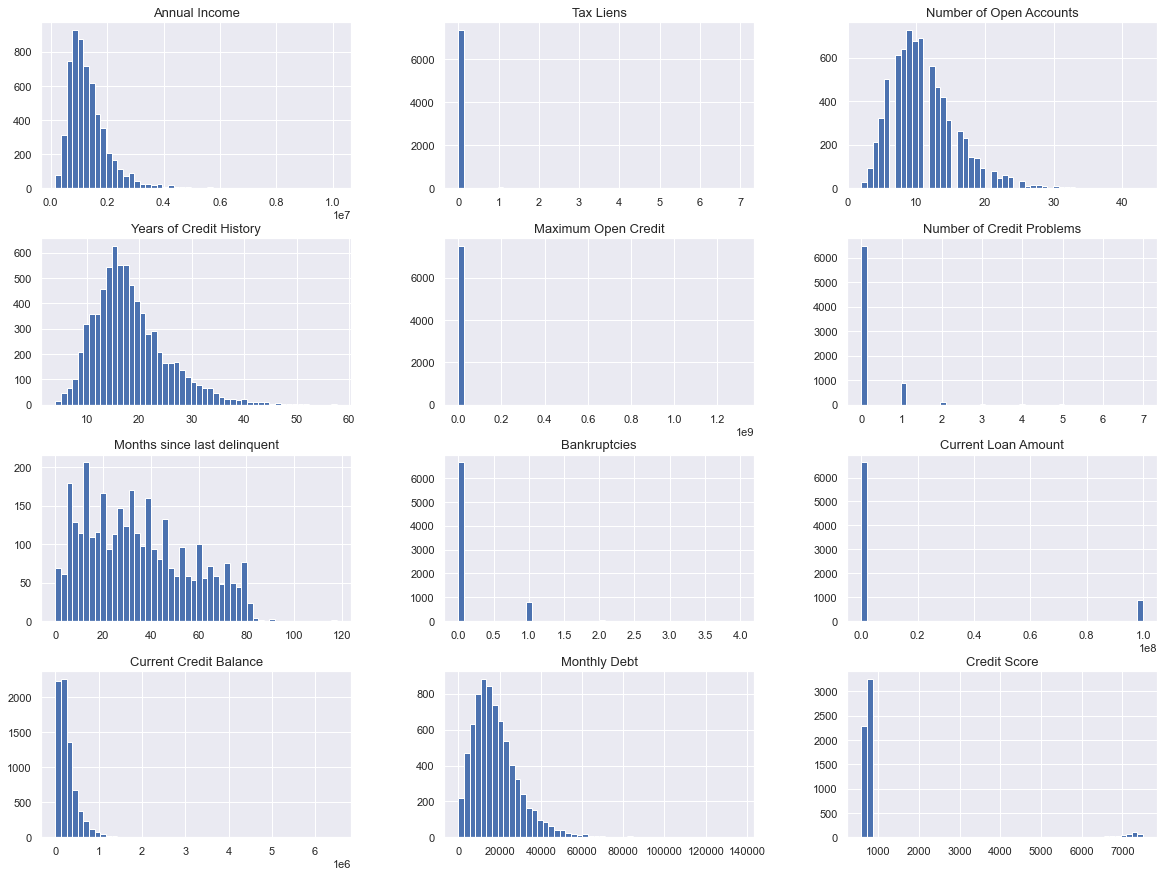

In [36]:
df[NUM_FEATURE_NAMES].hist(figsize=(20,15), bins=50, grid=True)
plt.show()

In [37]:
# Обработаем выбросы
df = fix_outlier(df)

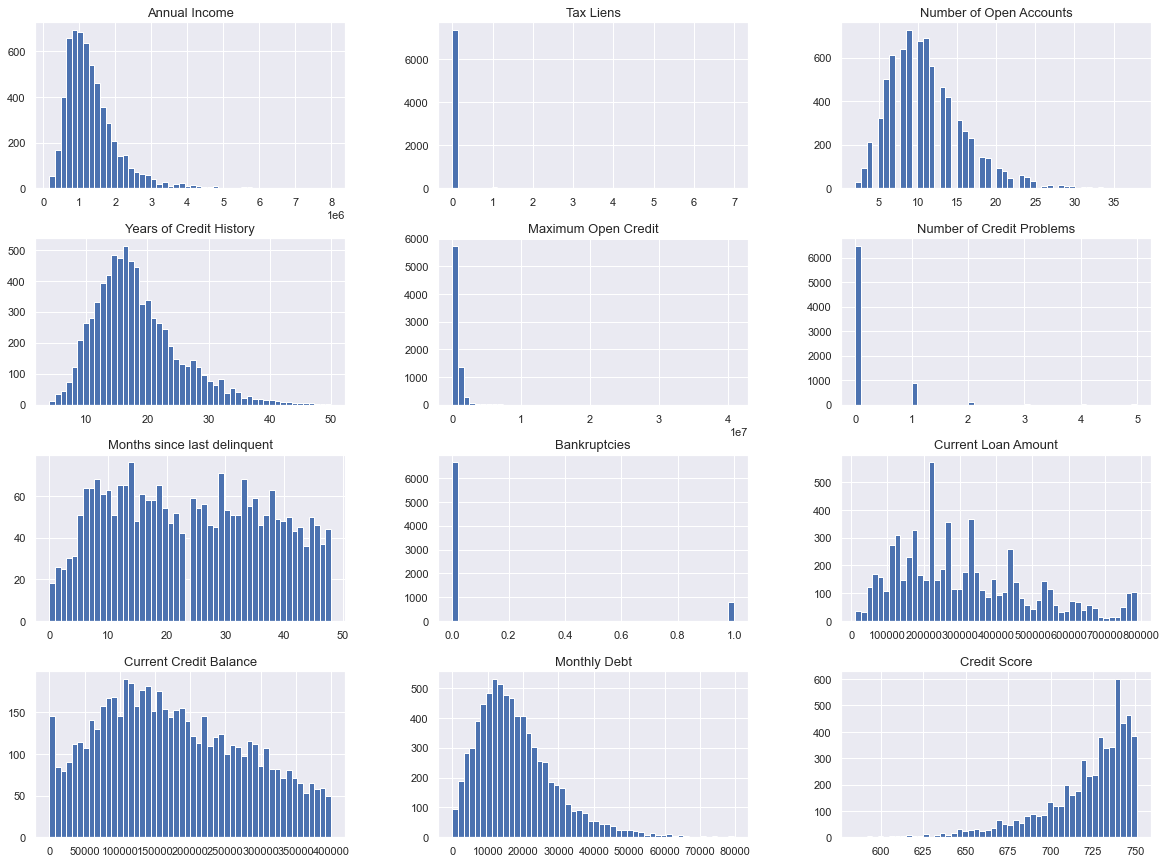

In [38]:
df[NUM_FEATURE_NAMES].hist(figsize=(20,15), bins=50, grid=True)
plt.show()

### Обработка пропусков

In [39]:
# Обработка пропусков
df = outliers(df)

In [40]:
df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### Построение новых признаков

In [41]:
# Переводим все категориальные признаки в dummies
df = dummies_col(df, CAT_FEATURE_NAMES)

In [43]:
# Удаляем набор признаков оставшихся в старом формате
df = drop_columns(df)

In [44]:
# Перегруппировка признаков по типам
TARGET_NAME, BASE_FEATURE_NAMES, NUM_FEATURE_NAMES, CAT_FEATURE_NAMES = features_group(df)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Annual Income                  7500 non-null   float64
 1   Tax Liens                      7500 non-null   float64
 2   Number of Open Accounts        7500 non-null   float64
 3   Years of Credit History        7500 non-null   float64
 4   Maximum Open Credit            7500 non-null   float64
 5   Number of Credit Problems      7500 non-null   float64
 6   Months since last delinquent   7500 non-null   float64
 7   Bankruptcies                   7500 non-null   float64
 8   Current Loan Amount            7500 non-null   float64
 9   Current Credit Balance         7500 non-null   float64
 10  Monthly Debt                   7500 non-null   float64
 11  Credit Score                   7500 non-null   float64
 12  Credit Default                 7500 non-null   i

### Корреляция признаков с целевой переменной

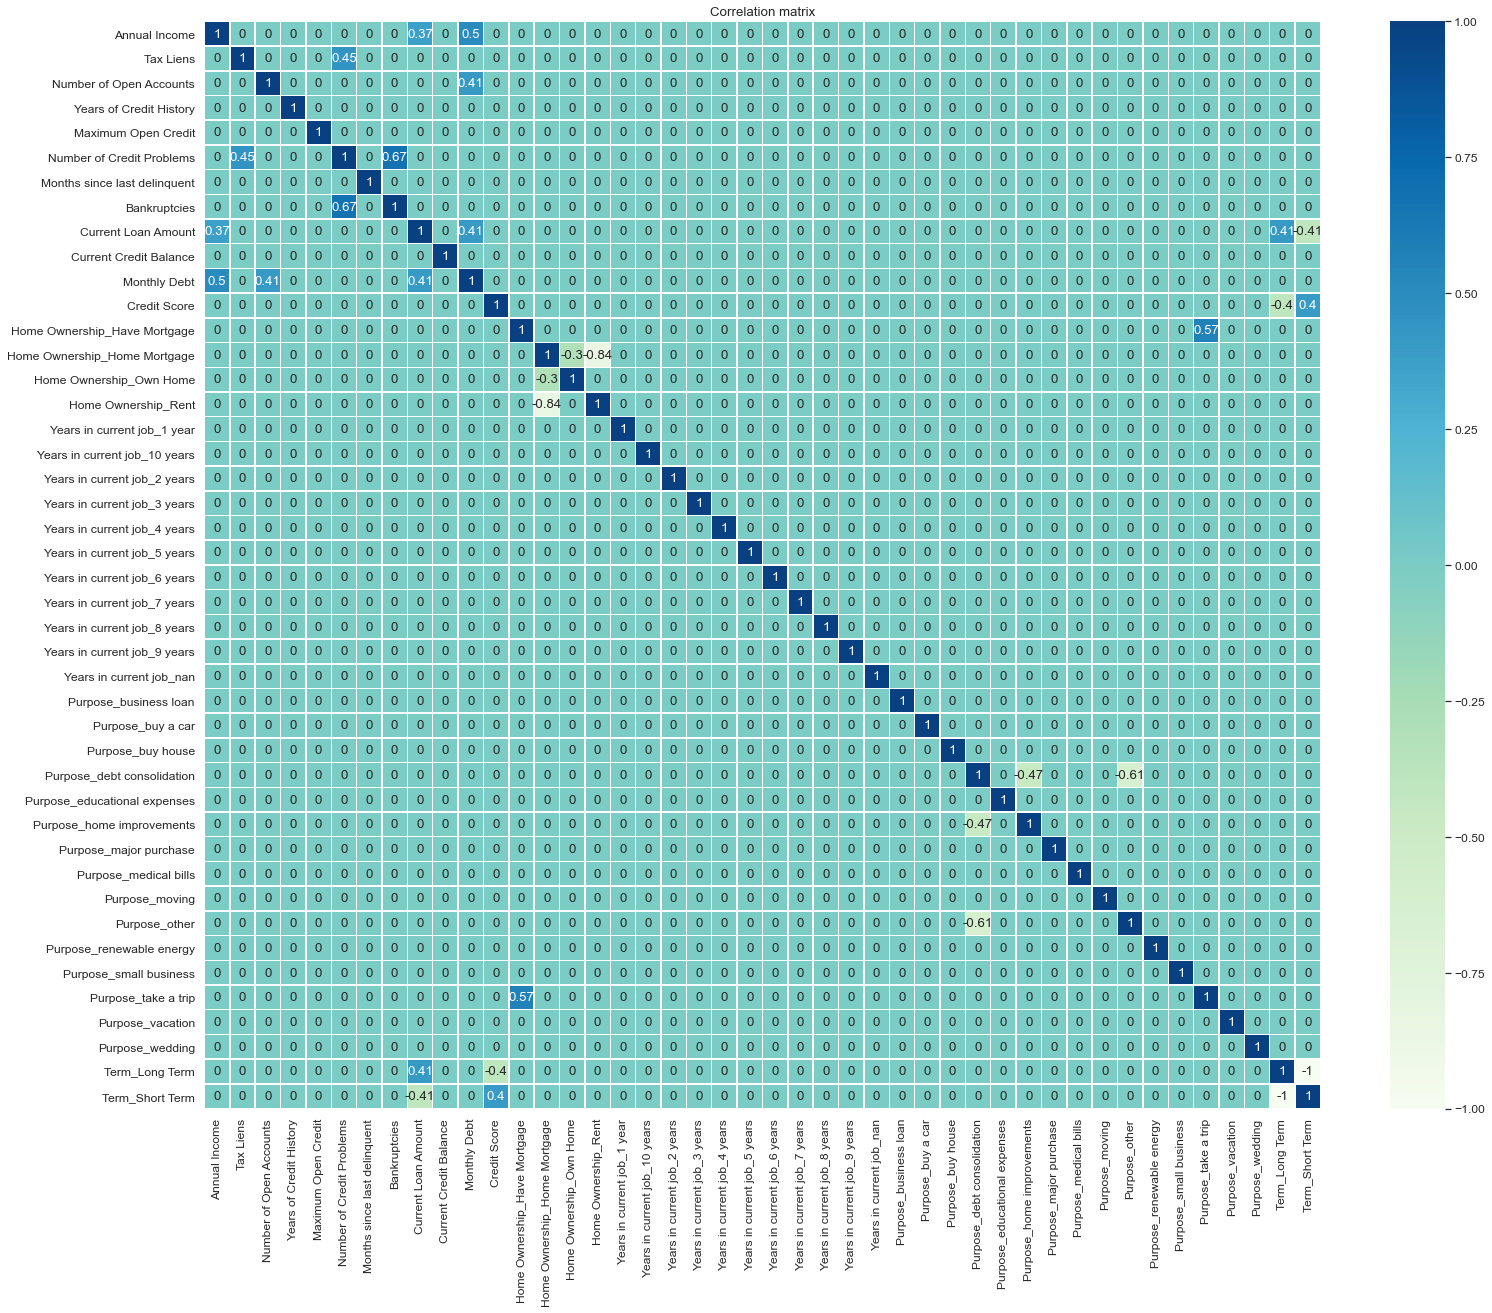

In [46]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.1)

corr_matrix = df[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

## Подбор и обучение моделей

### Нормализация данных

In [47]:
# Нормализация данных
df = normalization_df(df, NUM_FEATURE_NAMES)

### Балансировка класса

In [48]:
df = balance_df_by_target(df, TARGET_NAME, method='over')
df

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
6995,-0.093978,-0.110953,-0.845779,-0.328070,-0.120234,-0.350532,0.650641,-0.342153,-1.152561,0.231832,...,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,-0.591517,0.591517
6466,1.765477,3.571129,1.618503,1.570158,0.503204,1.761396,-0.589611,-0.342153,2.131479,0.000000,...,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,1.690569,-1.690569
5955,0.636368,-0.110953,-0.229708,0.189628,-0.053434,-0.350532,-0.589611,-0.342153,1.419935,-1.183648,...,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,1.690569,-1.690569
849,0.000000,-0.110953,0.591719,-0.414354,-0.460022,1.761396,-0.589611,2.922667,-1.343187,-0.970960,...,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,-0.591517,0.591517
2105,1.307206,-0.110953,-0.845779,-1.536034,0.331792,-0.350532,-0.589611,-0.342153,0.055768,0.181480,...,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,-0.591517,0.591517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3375,0.179397,-0.110953,-0.640422,-0.040460,-0.136378,-0.350532,-0.005963,-0.342153,0.164239,0.993997,...,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,-0.591517,0.591517
1468,-0.538096,-0.110953,0.591719,0.160867,-0.275319,-0.350532,-0.589611,-0.342153,-0.357706,0.673294,...,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,-0.591517,0.591517
6946,7.176551,-0.110953,1.618503,1.109981,0.675310,-0.350532,-0.589611,-0.342153,0.076820,0.000000,...,-0.097761,-0.038325,3.205962,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,-0.591517,0.591517
3671,-0.886991,-0.110953,-1.051135,-0.630061,0.084508,-0.350532,-0.589611,-0.342153,-0.300582,1.985145,...,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,-0.591517,0.591517


### Разбиение на train и test

In [49]:
# Разбиваем датасет на 2 части с использованием стратификации по целевой переменной

# Разделяем набор признаков
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]

# Разбиваем выборку на трейн и на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

# Выводим результат разбиения
X_train.shape, X_test.shape

((6729, 44), (2884, 44))

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9613 entries, 6995 to 4596
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Annual Income                  9613 non-null   float64
 1   Tax Liens                      9613 non-null   float64
 2   Number of Open Accounts        9613 non-null   float64
 3   Years of Credit History        9613 non-null   float64
 4   Maximum Open Credit            9613 non-null   float64
 5   Number of Credit Problems      9613 non-null   float64
 6   Months since last delinquent   9613 non-null   float64
 7   Bankruptcies                   9613 non-null   float64
 8   Current Loan Amount            9613 non-null   float64
 9   Current Credit Balance         9613 non-null   float64
 10  Monthly Debt                   9613 non-null   float64
 11  Credit Score                   9613 non-null   float64
 12  Home Ownership_Have Mortgage   9613 non-null 

### Обучение моделей

In [51]:
# Рассчитываем величину дисбаланса для деревьев решений
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance = round(disbalance, 2)
disbalance

1.27

#### KNN - k Ближайших Соседей

In [52]:
%%time
model_knn = KNeighborsClassifier()

model_knn.fit(X_train, y_train)

evaluate_preds(model_knn, X_train, X_test, y_train, y_test)


TRAIN

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      3771
           1       0.71      0.73      0.72      2958

    accuracy                           0.75      6729
   macro avg       0.75      0.75      0.75      6729
weighted avg       0.75      0.75      0.75      6729


TEST

              precision    recall  f1-score   support

           0       0.67      0.65      0.66      1616
           1       0.57      0.58      0.58      1268

    accuracy                           0.62      2884
   macro avg       0.62      0.62      0.62      2884
weighted avg       0.62      0.62      0.62      2884


CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1053  563
1                527  741
Wall time: 2.84 s


#### Дерево решений

In [53]:
%%time
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:disbalance},
                                    max_depth=4
                                    )

model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_test, y_train, y_test)


TRAIN

              precision    recall  f1-score   support

           0       0.72      0.62      0.67      3771
           1       0.59      0.69      0.64      2958

    accuracy                           0.65      6729
   macro avg       0.65      0.66      0.65      6729
weighted avg       0.66      0.65      0.65      6729


TEST

              precision    recall  f1-score   support

           0       0.71      0.63      0.67      1616
           1       0.59      0.68      0.63      1268

    accuracy                           0.65      2884
   macro avg       0.65      0.65      0.65      2884
weighted avg       0.66      0.65      0.65      2884


CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1011  605
1                406  862
Wall time: 41.9 ms


#### XGBoost

In [54]:
%%time
model_xgb = xgb.XGBClassifier(random_state=21,
                              max_depth=4
                             )

model_xgb.fit(X_train, y_train)

evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)


TRAIN

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3771
           1       0.89      0.81      0.85      2958

    accuracy                           0.87      6729
   macro avg       0.88      0.87      0.87      6729
weighted avg       0.87      0.87      0.87      6729


TEST

              precision    recall  f1-score   support

           0       0.75      0.80      0.78      1616
           1       0.72      0.67      0.69      1268

    accuracy                           0.74      2884
   macro avg       0.74      0.73      0.74      2884
weighted avg       0.74      0.74      0.74      2884


CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1295  321
1                422  846
Wall time: 640 ms


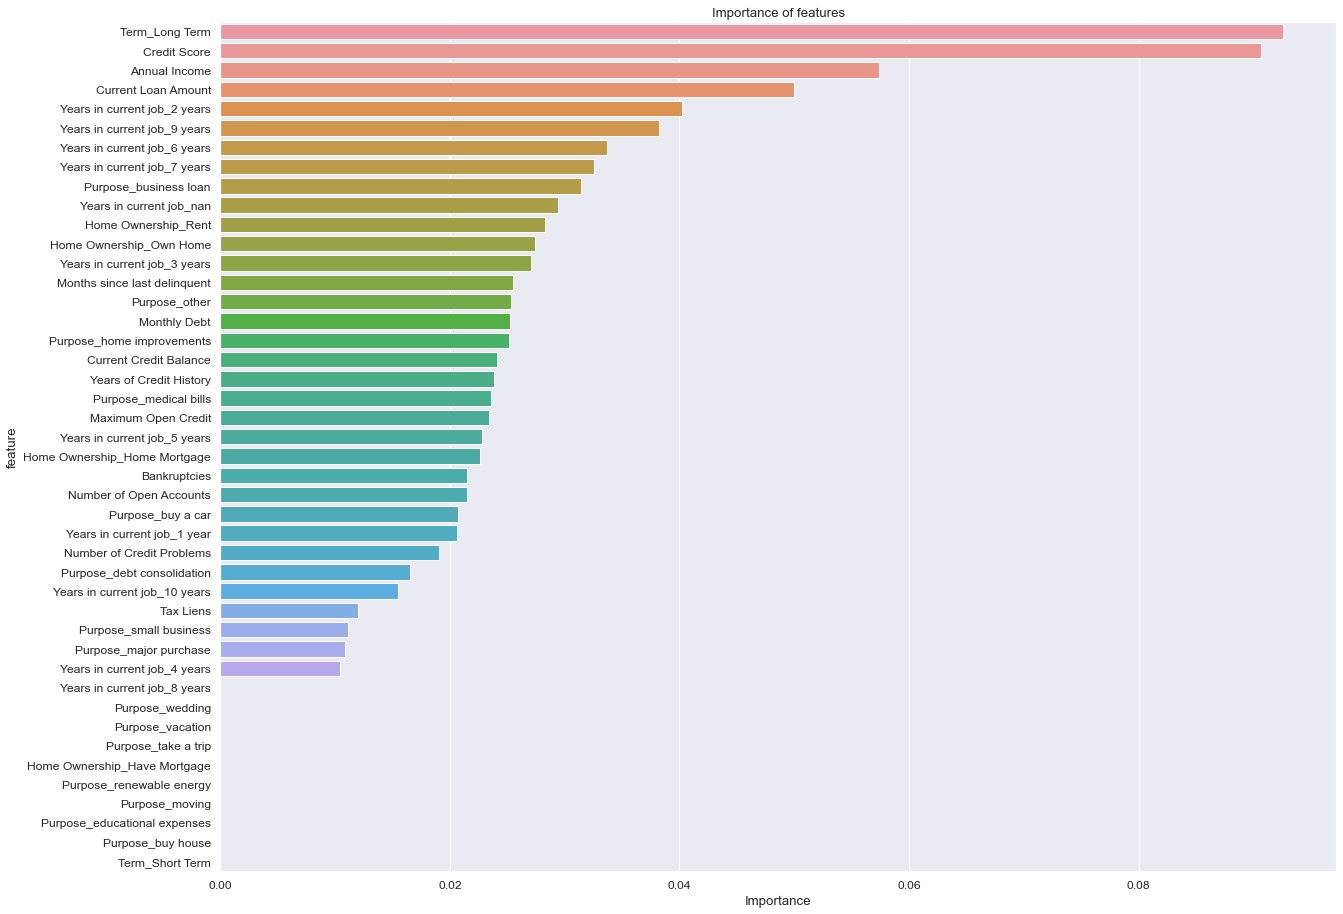

In [55]:
# Важность признаков для модели
important_features_top_xgb = show_feature_importances(X_train.columns,
                                                  model_xgb.feature_importances_, get_top=15)

In [56]:
%%time
model_xgb = xgb.XGBClassifier(random_state=21,
                              max_depth=3
                             )

model_xgb.fit(X_train[important_features_top_xgb], y_train)

evaluate_preds(model_xgb, X_train[important_features_top_xgb], X_test[important_features_top_xgb], y_train, y_test)


TRAIN

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      3771
           1       0.79      0.65      0.72      2958

    accuracy                           0.77      6729
   macro avg       0.78      0.76      0.76      6729
weighted avg       0.78      0.77      0.77      6729


TEST

              precision    recall  f1-score   support

           0       0.71      0.81      0.76      1616
           1       0.71      0.57      0.63      1268

    accuracy                           0.71      2884
   macro avg       0.71      0.69      0.69      2884
weighted avg       0.71      0.71      0.70      2884


CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1316  300
1                550  718
Wall time: 193 ms


#### LightGBM

In [57]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1, 1:disbalance},
                                 max_depth=4
                                )

model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)


TRAIN

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      3771
           1       0.75      0.80      0.77      2958

    accuracy                           0.79      6729
   macro avg       0.79      0.79      0.79      6729
weighted avg       0.79      0.79      0.79      6729


TEST

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      1616
           1       0.67      0.71      0.69      1268

    accuracy                           0.72      2884
   macro avg       0.71      0.72      0.71      2884
weighted avg       0.72      0.72      0.72      2884


CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1163  453
1                364  904
Wall time: 144 ms


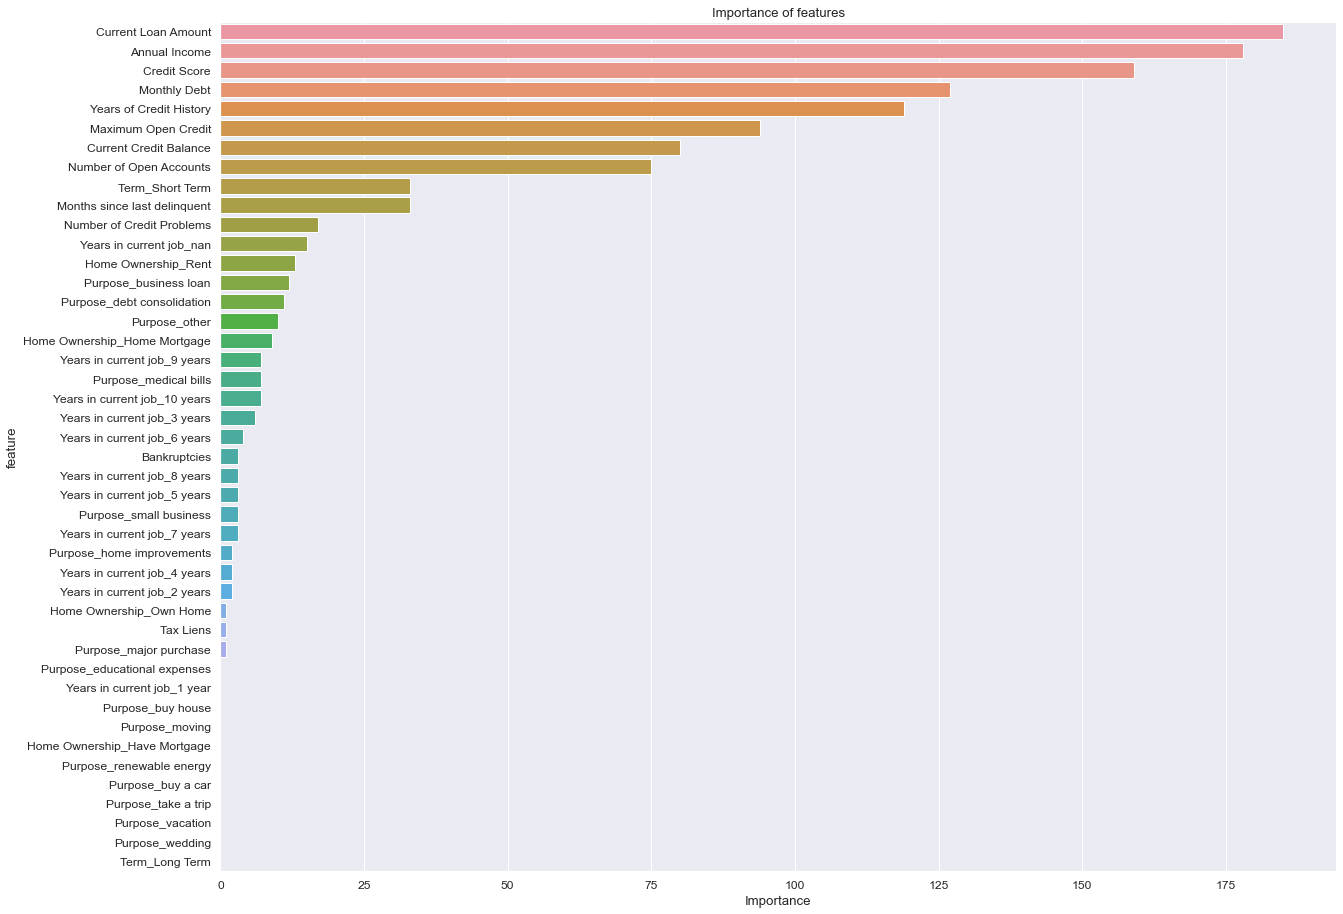

In [58]:
# Важность признаков для модели
important_features_top_lgbm = show_feature_importances(X_train.columns,
                                                  model_lgbm.feature_importances_, get_top=9)

In [59]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1, 1:disbalance},
                                 max_depth=4
                                )

model_lgbm.fit(X_train[important_features_top_lgbm], y_train)

evaluate_preds(model_lgbm, X_train[important_features_top_lgbm], X_test[important_features_top_lgbm], y_train, y_test)


TRAIN

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      3771
           1       0.73      0.78      0.75      2958

    accuracy                           0.78      6729
   macro avg       0.77      0.78      0.78      6729
weighted avg       0.78      0.78      0.78      6729


TEST

              precision    recall  f1-score   support

           0       0.75      0.70      0.72      1616
           1       0.65      0.70      0.67      1268

    accuracy                           0.70      2884
   macro avg       0.70      0.70      0.70      2884
weighted avg       0.70      0.70      0.70      2884


CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1137  479
1                386  882
Wall time: 105 ms


#### CatBoost

In [60]:
# CatBoost
model_catb = catb.CatBoostClassifier(silent=True, 
                                     random_state=21, 
                                     class_weights=[1, disbalance],
                                     max_depth=4
                                    )

model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)


TRAIN

              precision    recall  f1-score   support

           0       0.85      0.78      0.82      3771
           1       0.75      0.83      0.79      2958

    accuracy                           0.80      6729
   macro avg       0.80      0.81      0.80      6729
weighted avg       0.81      0.80      0.80      6729


TEST

              precision    recall  f1-score   support

           0       0.77      0.72      0.74      1616
           1       0.67      0.73      0.70      1268

    accuracy                           0.72      2884
   macro avg       0.72      0.72      0.72      2884
weighted avg       0.73      0.72      0.72      2884


CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1163  453
1                347  921


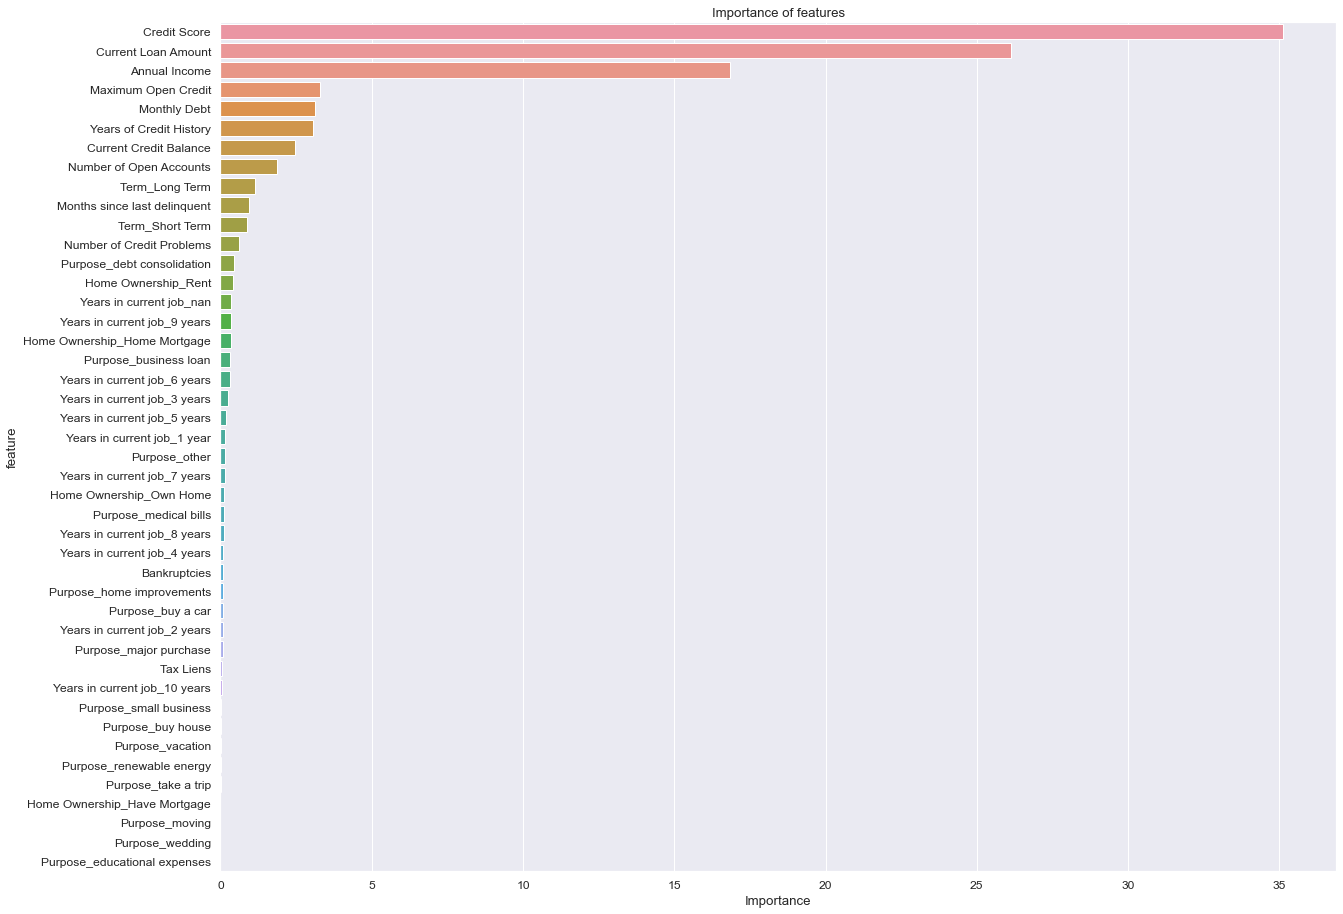

In [61]:
# Важность признаков для модели
important_features_top_catb = show_feature_importances(X_train.columns,
                                                  model_catb.feature_importances_, get_top=10)

In [62]:
# CatBoost
model_catb = catb.CatBoostClassifier(silent=True, 
                                     random_state=21, 
                                     class_weights=[1, disbalance],
                                     max_depth=3
                                    )

model_catb.fit(X_train[important_features_top_catb], y_train)

evaluate_preds(model_catb, X_train[important_features_top_catb], X_test[important_features_top_catb], y_train, y_test)


TRAIN

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      3771
           1       0.69      0.78      0.73      2958

    accuracy                           0.75      6729
   macro avg       0.75      0.75      0.75      6729
weighted avg       0.76      0.75      0.75      6729


TEST

              precision    recall  f1-score   support

           0       0.75      0.69      0.72      1616
           1       0.64      0.71      0.67      1268

    accuracy                           0.70      2884
   macro avg       0.70      0.70      0.70      2884
weighted avg       0.70      0.70      0.70      2884


CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1108  508
1                364  904


### Настройка гиперпараметров выбранной модели

In [63]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
#      'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

model_catb = catb.CatBoostClassifier(**frozen_params)

In [64]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 4, 5, 6, 7]}

In [65]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [66]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6822985947
bestIteration = 40

0:	loss: 0.6822986	best: 0.6822986 (0)	total: 136ms	remaining: 3.27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6951495205
bestIteration = 101

1:	loss: 0.6951495	best: 0.6951495 (1)	total: 388ms	remaining: 4.46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6951495205
bestIteration = 101

2:	loss: 0.6951495	best: 0.6951495 (1)	total: 618ms	remaining: 4.54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6951495205
bestIteration = 101

3:	loss: 0.6951495	best: 0.6951495 (1)	total: 856ms	remaining: 4.49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6951495205
bestIteration = 101

4:	loss: 0.6951495	best: 0.6951495 (1)	total: 1.12s	remaining: 4.48s

bestTest = 0.6888926626
bestIteration = 49

5:	loss: 0.6888927	best: 0.6951495 (1)	total: 1.26s	remaining: 4.01s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.702753937
bestIteration = 13

In [67]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
100,100,0.703432,0.013986,0.757901,0.006207,0.571135,0.005179,0.528720,0.006095
96,96,0.702684,0.015794,0.755173,0.005628,0.571864,0.005070,0.531053,0.005923
99,99,0.702623,0.014570,0.757146,0.006589,0.571288,0.005201,0.529292,0.005970
104,104,0.702291,0.013888,0.760588,0.005322,0.570064,0.004525,0.526079,0.006625
98,98,0.702262,0.015076,0.757191,0.006897,0.571476,0.004947,0.529763,0.005870


In [68]:
%%time

final_model = catb.CatBoostClassifier(**frozen_params, iterations=50, max_depth=3)
final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


TRAIN

              precision    recall  f1-score   support

           0       0.76      0.57      0.65      3771
           1       0.59      0.77      0.66      2958

    accuracy                           0.66      6729
   macro avg       0.67      0.67      0.66      6729
weighted avg       0.68      0.66      0.66      6729


TEST

              precision    recall  f1-score   support

           0       0.75      0.56      0.64      1616
           1       0.58      0.76      0.66      1268

    accuracy                           0.65      2884
   macro avg       0.66      0.66      0.65      2884
weighted avg       0.67      0.65      0.65      2884


CONFUSION MATRIX

col_0             0    1
Credit Default          
0               912  704
1               307  961
Wall time: 152 ms


## РЕШЕНИЕ. Прогноз на тестовом датасете

### Загрузка и подготовка данных

In [69]:
TEST_DATASET_PATH = 'test.csv'
df_test = pd.read_csv(TEST_DATASET_PATH)

In [70]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

### Прогнозирование целевой переменной

In [71]:
# Группировка признаков по типам
TARGET_NAME, BASE_FEATURE_NAMES, NUM_FEATURE_NAMES, CAT_FEATURE_NAMES = features_group(df_test)

In [72]:
# Приведение типов
df_test = astype_col(df_test, CAT_FEATURE_NAMES, coltype='str')

In [73]:
# Обработка выбросов
df_test = fix_outlier(df_test)

In [74]:
# Обработка пропусков
df_test = outliers(df_test)

In [75]:
df_test.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

In [76]:
# Переводим категориальные признаки в dummies
df_test = dummies_col(df_test, CAT_FEATURE_NAMES)

In [77]:
# Удаляем набор признаков оставшихся в старом формате
df_test = drop_columns(df_test)

In [78]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Annual Income                  2500 non-null   float64
 1   Tax Liens                      2500 non-null   float64
 2   Number of Open Accounts        2500 non-null   float64
 3   Years of Credit History        2500 non-null   float64
 4   Maximum Open Credit            2500 non-null   float64
 5   Number of Credit Problems      2500 non-null   float64
 6   Months since last delinquent   2500 non-null   float64
 7   Bankruptcies                   2500 non-null   float64
 8   Current Loan Amount            2500 non-null   float64
 9   Current Credit Balance         2500 non-null   float64
 10  Monthly Debt                   2500 non-null   float64
 11  Credit Score                   2500 non-null   float64
 12  Home Ownership_Have Mortgage   2500 non-null   u

In [79]:
# Нормализация данных
df_test = normalization_df(df_test, NUM_FEATURE_NAMES)

In [80]:
# Запускаем обучение на тестовых данных
final_prediction = final_model.predict(df_test)

In [81]:
# Добавляем таргет к датасету и считаем кол-во предсказаний
df_test['Credit Default'] = final_prediction
df_test['Credit Default'].value_counts()

0    1390
1    1110
Name: Credit Default, dtype: int64

### Сохранение результатов

In [82]:
preds_final = pd.DataFrame()
preds_final = pd.DataFrame({'Id': df_test.index, 'Credit Default': final_prediction})
preds_final.to_csv('predictions.csv', index=False, encoding='utf-8', sep=',')
preds_final.head(10)

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
5,5,0
6,6,0
7,7,1
8,8,1
9,9,0


In [83]:
# Сохранение финальной модели
with open('final_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)